In [123]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)

In [124]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

data_raw = pd.read_csv("STAT_444_project_data_power_transformed_noNA.csv", low_memory = True)

#data_raw.reset_index(drop=True, inplace=True)
dates = pd.date_range(start='2018-01-01', periods=1946)

data_raw1 = data_raw.copy()
data_raw1['date'] = dates
data_raw1.set_index(['date'], inplace=True)
data_raw = data_raw.drop(["date_1","date_2", "temp2_c", "temp2_min_c",
            "wind_speed50_ave_m_s","max_generation_mw", "day","year", "month"], axis=1)
split_index = int(0.9 * len(data_raw))  # 90% for training, 10% for testing
df_train = data_raw[:split_index] 
df_test = data_raw[split_index:]


#train_x_raw = pd.read_csv("../01-Data/X_train.csv", low_memory = True, index_col=0)
#train_y_raw = pd.read_csv("../01-Data/y_train.csv", low_memory = True, index_col=0)
#test_x_raw = pd.read_csv("../01-Data/X_test.csv", low_memory=True, index_col=0)



In [125]:
df_z_scaled = df_train.copy()
df_tz = df_test.copy()
# apply normalization techniques 
for column in df_z_scaled.columns:
    df_z_scaled[column] = df_z_scaled[column].astype(float)
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / (df_z_scaled[column].std())

for column in df_tz.columns:
    df_tz[column] = df_tz[column].astype(float)
    df_tz[column] = (df_tz[column] -
                           df_tz[column].mean()) / (df_tz[column].std())

In [126]:
df_z_scaled = df_z_scaled.astype(float)
df_tz = df_tz.astype(float)

In [127]:
df_xtrain = df_z_scaled.drop(['total_demand_mw'], axis=1)
df_xtest = df_tz.drop(['total_demand_mw'], axis=1)
df_ytrain = df_z_scaled['total_demand_mw']
df_ytest = df_tz['total_demand_mw']

df_xtrain

,temp2_max_c,temp2_ave_c,surface_pressure_pa,wind_speed50_max_m_s,wind_speed50_min_m_s,prectotcorr
0,-1.266798,-1.120188,0.685131,-0.392145,-1.892482,-1.178404
1,-1.479151,-1.118095,0.432774,0.208989,-0.240547,-0.927928
2,-1.555901,-1.152093,0.757812,0.587827,0.818175,-0.586996
3,-1.870573,-1.167826,1.162218,0.060807,-0.276353,-0.449363
4,-1.811731,-1.167105,0.849029,0.117265,0.587405,-1.178404
...,...,...,...,...,...,...
1746,-0.241011,-0.230273,0.379106,-0.544505,0.400778,0.647945
1747,-0.091654,-0.149750,0.289978,-1.189379,-0.157717,0.686017
1748,-0.086825,-0.318682,0.254438,-0.084349,0.449166,-0.007113
1749,0.088150,-0.391043,0.540541,-0.126217,-0.059717,-0.268152


In [128]:
df_xtrain1 = np.array(df_xtrain.values).reshape(len(df_xtrain), 1, 6)
df_xtest1 = np.array(df_xtest.values).reshape(len(df_xtest), 1, 6)
df_tensor_ytr = np.array(df_ytrain.values)
df_tensor_yte = np.array(df_ytest.values)

In [129]:

multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.LSTM(200, input_shape=(df_xtrain1.shape[1], df_xtrain1.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(1, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 200)            │       165,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,801 (647.66 KB)

 Trainable params: 165,801 (647.66 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:

history = multivariate_lstm.fit(df_xtrain1, df_tensor_ytr, epochs=100)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MAE: 0.7295 - loss: 0.7646  
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.5286 - loss: 0.4868
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.5128 - loss: 0.4481
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.5042 - loss: 0.4304
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.5016 - loss: 0.4246
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.4948 - loss: 0.4132
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.4919 - loss: 0.4045
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.4846 - loss: 0.3965
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.4843 - loss: 0.3921
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.4843 - loss: 0.3908
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.4797 - loss: 0.3839
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAE: 0.4768 - loss: 0.3839
Epoch 13/100
55/55 ━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step


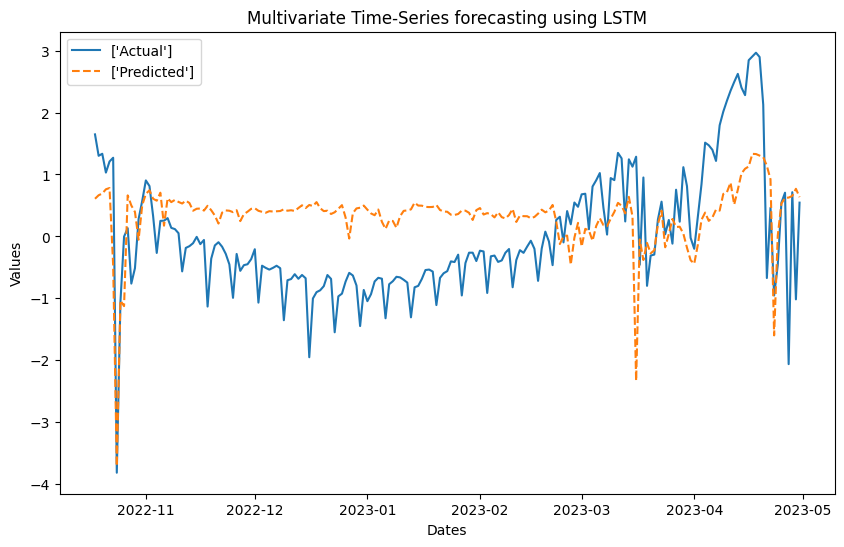

In [136]:

 
# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(df_xtest1)
 
d = {
    'Predicted': predicted_values[:, 0],
    'Actual': df_ytest[:]
}
 
d = pd.DataFrame(d)
d.index = data_raw1.index[-len(df_ytest):]  # Assigning the correct date index
 
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the actual values
plt.plot(d['Actual'], label=['Actual'])
 
# Plot predicted values with a dashed line
plt.plot(d['Predicted'], label=['Predicted'], linestyle='--')
 
# Highlight the forecasted portion with a different color

 
plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [132]:
submission_df = pd.DataFrame(predicted_values)

submission_df.insert(0, 'id', df_test.index)

# Save the submission file
submission_file = ('LSTMtimeseries_final.csv')
submission_df.to_csv(submission_file, index=False)